In [4]:
import numpy as np
import glob
from annoy import AnnoyIndex
import torch
import matplotlib.pyplot as plt

# Important so PyTorch can load LSTM Model Weights
from Utils.PTModel.Models import LSTMModel

MODELNAME = "TestVAEwATT"

In [2]:
bbEmbeddingPath = f"Models/{MODELNAME}/LevelUnifiedRep/BubbleBobble"

columnRefArray = np.array([i+1 for i in range(13) for j in range(12)])

bbEmbeddingPaths = sorted(glob.glob(f"{bbEmbeddingPath}/level*.npy"))

In [5]:
model = torch.load(f"Models/{MODELNAME}/BubbleBobbleLSTM.pt")

/tmp/ipykernel_4399/3074632917.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f"Models/{MODELNAME}/BubbleBobbleLSTM.pt")


tileMap shape: (14820, 16, 16, 3)
embedMap shape: (14820, 256)
Maps Loaded
Initialised Tree
Building Tree
Tree Built
Annoy Map Trained
Random Start Point: 37
Input shape: (78, 78, 256)
input size: torch.Size([78, 256])
target shape: (78, 78, 256)
target size: torch.Size([78, 256])
column shape: (78, 78, 256)
column size: torch.Size([78, 256])
Running Model
next col size: (78, 256)
Input shape: (78, 78, 256)
input size: torch.Size([78, 256])
target shape: (78, 78, 256)
target size: torch.Size([78, 256])
column shape: (78, 78, 256)
column size: torch.Size([78, 256])
Running Model
next col size: (78, 256)
Input shape: (78, 78, 256)
input size: torch.Size([78, 256])
target shape: (78, 78, 256)
target size: torch.Size([78, 256])
column shape: (78, 78, 256)
column size: torch.Size([78, 256])
Running Model
next col size: (78, 256)
Input shape: (78, 78, 256)
input size: torch.Size([78, 256])
target shape: (78, 78, 256)
target size: torch.Size([78, 256])
column shape: (78, 78, 256)
column size:

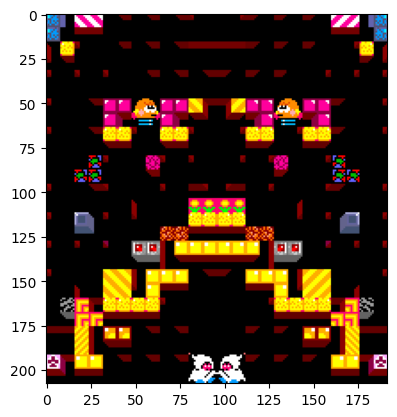

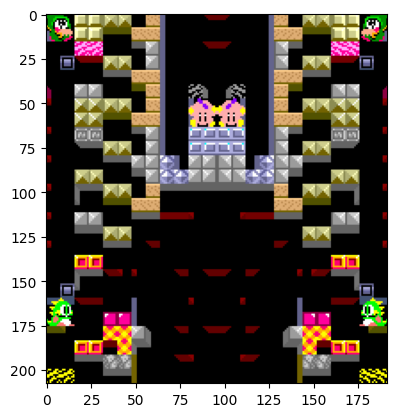

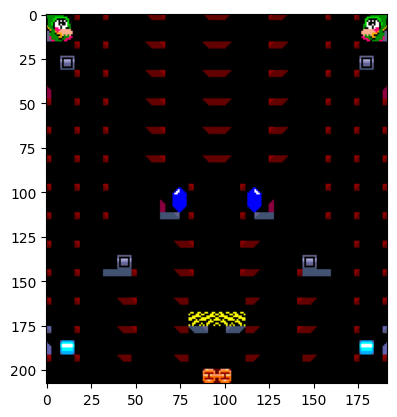

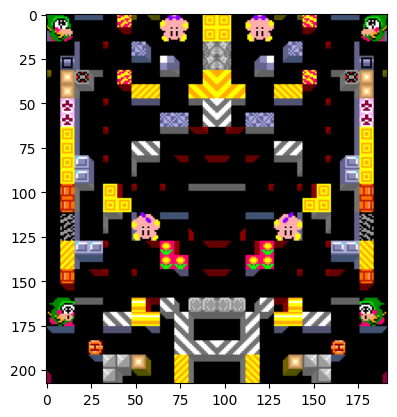

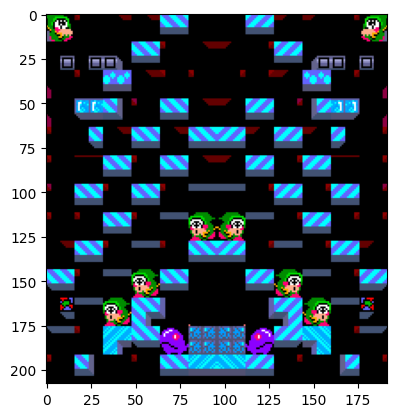

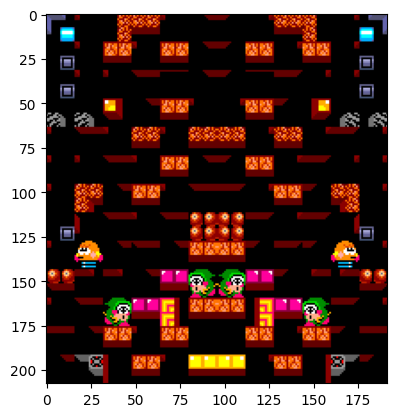

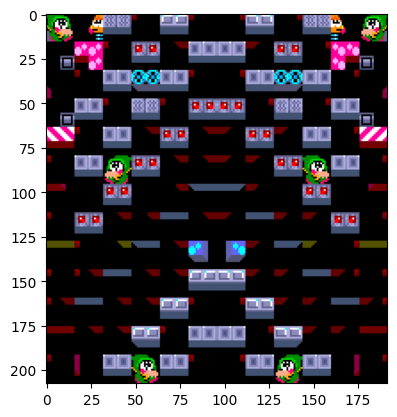

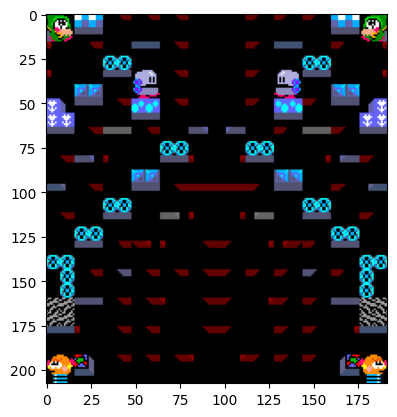

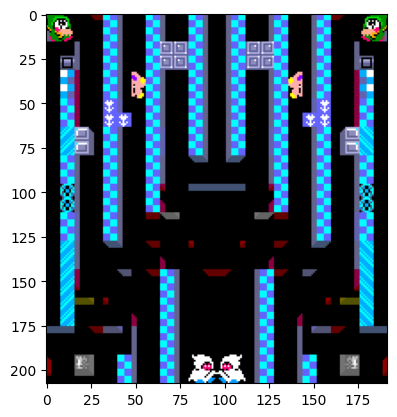

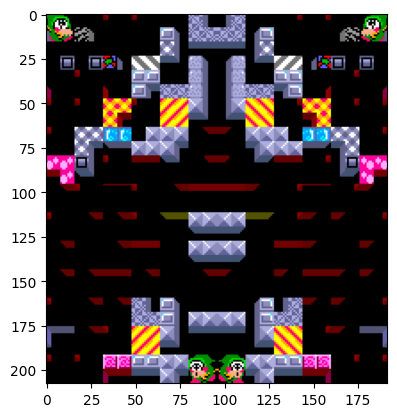

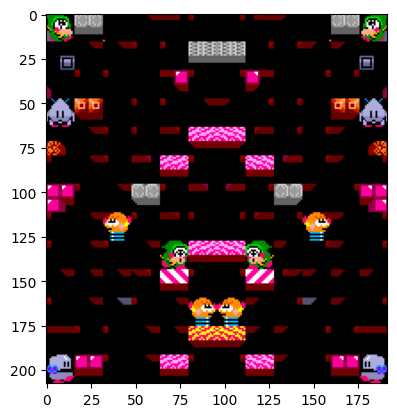

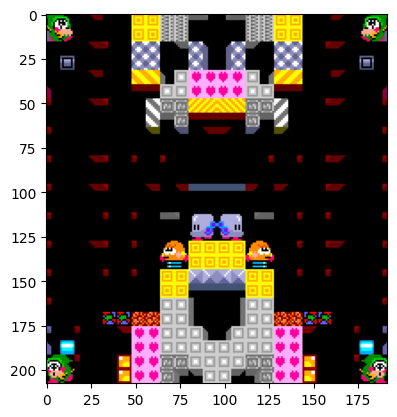

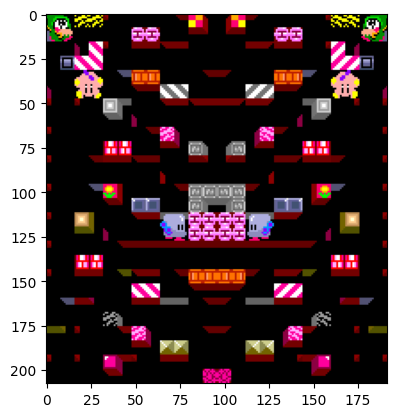

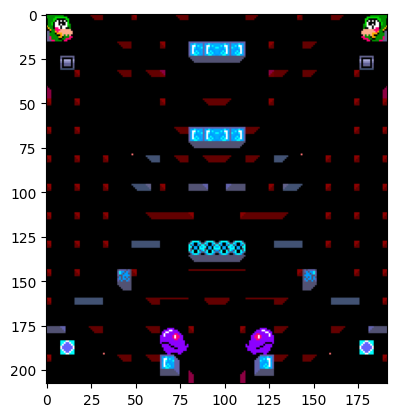

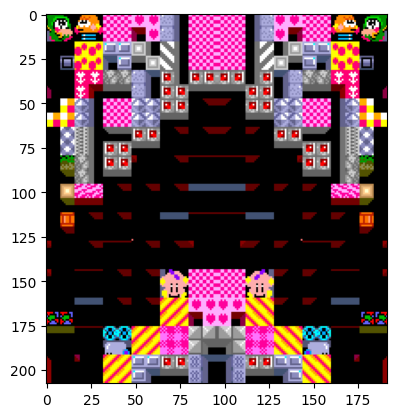

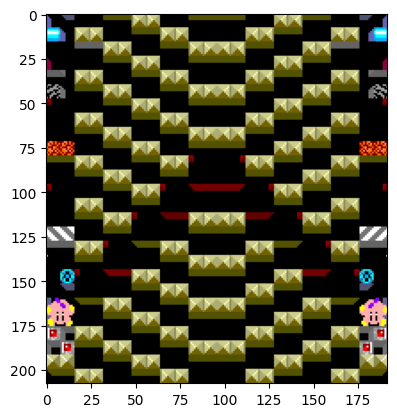

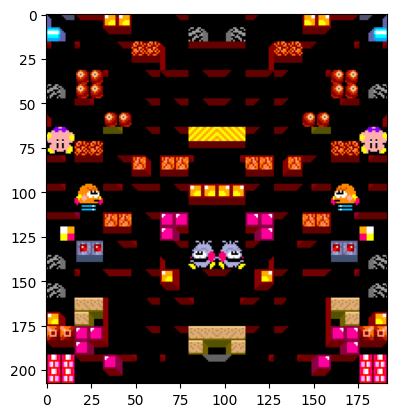

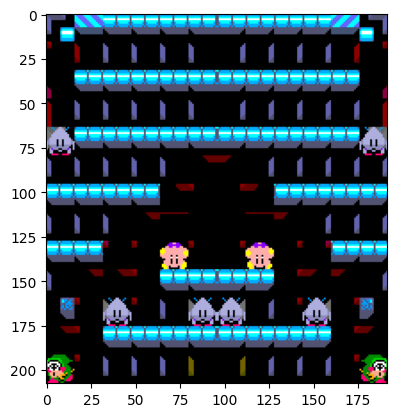

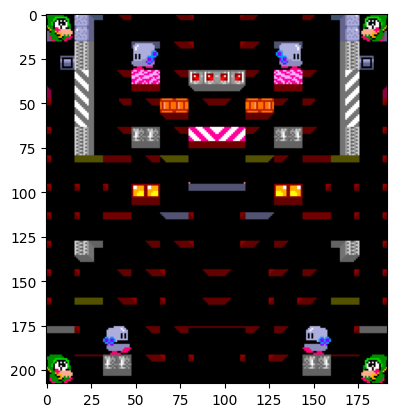

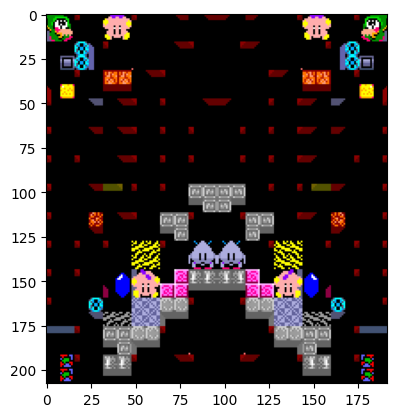

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)
model.eval()

tileMap = np.load(f"{bbEmbeddingPath}/centerTiles.npy")
embedMap = np.load(f"{bbEmbeddingPath}/embeddings.npy")

print(f"tileMap shape: {tileMap.shape}")
print(f"embedMap shape: {embedMap.shape}")

print("Maps Loaded")

nnTree = AnnoyIndex(256, 'euclidean')

print("Initialised Tree")

#for i in range(embedMap.shape[0]): print(f"Added {i}th item to tree"), nnTree.add_item(i, embedMap[i])
for i in range(embedMap.shape[0]): nnTree.add_item(i, embedMap[i])

print("Building Tree")
nnTree.build(15)
print("Tree Built")

print("Annoy Map Trained")

N = 78
NLevels = 20

np.random.seed(1)
randStartPoint = np.random.randint(0, len(bbEmbeddingPaths)-NLevels)
print(f"Random Start Point: {randStartPoint}")

for i, levelEmbeddingPath in enumerate(bbEmbeddingPaths[randStartPoint:randStartPoint+NLevels]):

    input = []
    column = []
    target = []

    levelEmbeddingArray = np.load(levelEmbeddingPath)
    #levelEmbeddingArray = get_pickle(levelEmbeddingPath)

    for j in range(len(levelEmbeddingArray) - N):

        padLength = N - j

        dataI = np.concatenate((np.zeros(shape=(padLength, 256)), levelEmbeddingArray[:j]), axis=0)

        dataT = levelEmbeddingArray[j:j+N]

        levelIdx = np.concatenate((np.zeros(shape=(padLength)), columnRefArray[:j]), axis=0)
        dataC = np.zeros(shape=(N, 256))
        for j in range(N): dataC[j][int(levelIdx[j])] = 1

        column.append(dataC)
        input.append(dataI)
        target.append(dataT)

    input = np.array(input)
    print(f"Input shape: {input.shape}")
    #input = torch.tensor(input[0].reshape(256, N), dtype=torch.float32).to(device)
    input = torch.tensor(input[0], dtype=torch.float32).to(device)
    print(f"input size: {input.size()}")

    target = np.array(target)
    print(f"target shape: {target.shape}")
    #target = torch.tensor(target[0].reshape(256, N), dtype=torch.float32).to(device)
    target = torch.tensor(target[0], dtype=torch.float32).to(device)
    print(f"target size: {target.size()}")

    column = np.array(column)
    print(f"column shape: {column.shape}")
    #column = torch.tensor(column[0].reshape(256, N), dtype=torch.float32).to(device)
    column = torch.tensor(column[0], dtype=torch.float32).to(device)
    print(f"column size: {column.size()}")

    print("Running Model")

    nextCol = model(input, target, column)
    nextCol = nextCol.cpu().detach().numpy()
    print(f"next col size: {nextCol.shape}")
    #nextCol = nextCol[:, :78].reshape(6, 13, nextCol.shape[0]).transpose(1, 0, 2)
    nextCol = nextCol.reshape(6, 13, nextCol.shape[1]).transpose(1, 0, 2)

    levelImage = np.zeros(shape=(nextCol.shape[0] * 16, nextCol.shape[1] * 16, 3), dtype=np.uint8)

    for t, row in enumerate(nextCol):
        for j, embedding in enumerate(row):

            nearestEmbedding = nnTree.get_nns_by_vector(embedding, 2, search_k=-1, include_distances=False)[0]
            tileImage = tileMap[nearestEmbedding]

            levelImage[t*16 : t*16+16, j*16 : j*16+16, :] = tileImage

    levelImage = np.concatenate([levelImage, np.fliplr(levelImage)], axis=1)

    plt.figure()
    plt.imshow(levelImage)